#### The selection follows [Supporting Document:  The Search for Resonant HH Production Decaying to the4b Final State Using the Full Run-2 Data and the Boosted Analysis Channel](https://cds.cern.ch/record/2708599)

In [1]:
import uproot
import pyjet
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import sys, os
import importlib
import time
from tqdm import tqdm

from BranchClass import *

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
from matplotlib.collections import LineCollection
from matplotlib import cm


## Define Function for Invariant Mass, Transverse Mass


In [2]:
def M(pt1,eta1,phi1,m1,pt2,eta2,phi2,m2):
    px1, py1, pz1 = pt1*np.cos(phi1), pt1*np.sin(phi1), np.sqrt(m1**2+pt1**2)*np.sinh(eta1)
    e1 = np.sqrt(m1**2 + px1**2 + py1**2 + pz1**2)
    px2, py2, pz2 = pt2*np.cos(phi2), pt2*np.sin(phi2), np.sqrt(m2**2+pt2**2)*np.sinh(eta2)
    e2 = np.sqrt(m2**2 + px2**2 + py2**2 + pz2**2)
    
    return np.sqrt((e1+e2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2)

def Mbbbb(j1,j2,j3,j4):
    pt1, eta1, phi1, m1 = j1.pt,j1.eta,j1.phi,j1.mass
    pt2, eta2, phi2, m2 = j2.pt,j2.eta,j2.phi,j2.mass
    pt3, eta3, phi3, m3 = j3.pt,j3.eta,j3.phi,j3.mass
    pt4, eta4, phi4, m4 = j4.pt,j4.eta,j4.phi,j4.mass
    
    px1, py1, pz1 = pt1*np.cos(phi1), pt1*np.sin(phi1), np.sqrt(m1**2+pt1**2)*np.sinh(eta1)
    e1 = np.sqrt(m1**2 + px1**2 + py1**2 + pz1**2)
    px2, py2, pz2 = pt2*np.cos(phi2), pt2*np.sin(phi2), np.sqrt(m2**2+pt2**2)*np.sinh(eta2)
    e2 = np.sqrt(m2**2 + px2**2 + py2**2 + pz2**2)
    
    px3, py3, pz3 = pt3*np.cos(phi3), pt3*np.sin(phi3), np.sqrt(m3**2+pt3**2)*np.sinh(eta3)
    e3 = np.sqrt(m3**2 + px3**2 + py3**2 + pz3**2)
    px4, py4, pz4 = pt4*np.cos(phi4), pt4*np.sin(phi4), np.sqrt(m4**2+pt4**2)*np.sinh(eta4)
    e4 = np.sqrt(m4**2 + px4**2 + py4**2 + pz4**2)
    
    return np.sqrt((e1+e2+e3+e4)**2-(px1+px2+px3+px4)**2-(py1+py2+py3+py4)**2-(pz1+pz2+pz3+pz4)**2)

def MJJ(j1,j2):
    pt1, eta1, phi1, m1 = j1.pt,j1.eta,j1.phi,j1.mass
    pt2, eta2, phi2, m2 = j2.pt,j2.eta,j2.phi,j2.mass
    
    px1, py1, pz1 = pt1*np.cos(phi1), pt1*np.sin(phi1), np.sqrt(m1**2+pt1**2)*np.sinh(eta1)
    e1 = np.sqrt(m1**2 + px1**2 + py1**2 + pz1**2)
    px2, py2, pz2 = pt2*np.cos(phi2), pt2*np.sin(phi2), np.sqrt(m2**2+pt2**2)*np.sinh(eta2)
    e2 = np.sqrt(m2**2 + px2**2 + py2**2 + pz2**2)
    
    return np.sqrt((e1+e2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2)


def MT(pt1,eta1,phi1,m1,pt2,eta2,phi2,m2,missingET,missingETA,missingPHI):
    px1, py1, pz1 = pt1*np.cos(phi1), pt1*np.sin(phi1), np.sqrt(m1**2+pt1**2)*np.sinh(eta1)
    e1 = np.sqrt(m1**2 + px1**2 + py1**2 + pz1**2)
    px2, py2, pz2 = pt2*np.cos(phi2), pt2*np.sin(phi2), np.sqrt(m2**2+pt2**2)*np.sinh(eta2)
    e2 = np.sqrt(m2**2 + px2**2 + py2**2 + pz2**2)
    
    px_missing, py_missing = missingET*np.cos(missingPHI), missingET*np.sin(missingPHI)
    
    EllT = np.sqrt((px1+px2)**2 + (py1+py2)**2 +  M(pt1,eta1,phi1,m1,pt2,eta2,phi2,m2)**2 )

    MT = np.sqrt( (EllT+missingET)**2 - (px1+px2+px_missing)**2 - (py1+py2+py_missing)**2 )
    
    return MT
    
def PxPyPzE(pt,eta,phi,m):
    px, py, pz = pt*np.cos(phi), pt*np.sin(phi), np.sqrt(m**2+pt**2)*np.sinh(eta)
    e = np.sqrt(m**2 + px**2 + py**2 + pz**2)
    
    return px, py, pz, e    

def PtEtaPhiM(px, py, pz, e):
    E, px ,py, pz = e, px, py, pz  
    P = np.sqrt(px**2 + py**2 + pz**2)
    pt = np.sqrt(px**2 + py**2)
    eta = 1./2.*np.log((P + pz)/(P - pz))
    phi = np.arctan(py/px)
    m = np.sqrt(np.sqrt((E**2 - px**2 - py**2 - pz**2)**2))

    return pt, eta, phi, m

def ET(jet):
    pt = jet.pt
    m = jet.mass
    ET = np.sqrt(m**2 + pt**2)
    return  ET


def XHH(jet1, jet2):
    m1, m2 = jet1.mass, jet2.mass
    XHH = np.sqrt( (m1-124)**2/(0.1*m1) + (m2-115)**2/(0.1*m2))
    return  XHH

def DeltaR(eta1,phi1, eta2,phi2):
    dEta = eta1-eta2
    dPhi = abs(phi1-phi2)
    if dPhi > np.pi:
        dPhi = 2*np.pi - dPhi

    dR = (dPhi**2 + dEta**2)**0.5

    return dR

def FourVectorbb(pt1,eta1,phi1,m1,pt2,eta2,phi2,m2):
    px1, py1, pz1 = pt1*np.cos(phi1), pt1*np.sin(phi1), np.sqrt(m1**2+pt1**2)*np.sinh(eta1)
    e1 = np.sqrt(m1**2 + px1**2 + py1**2 + pz1**2)
    px2, py2, pz2 = pt2*np.cos(phi2), pt2*np.sin(phi2), np.sqrt(m2**2+pt2**2)*np.sinh(eta2)
    e2 = np.sqrt(m2**2 + px2**2 + py2**2 + pz2**2)
    
    m = np.sqrt((e1+e2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2)
    pt = np.sqrt((px1+px2)**2 + (py1+py2)**2)
    eta = np.arcsinh((pz1+pz2)/np.sqrt(m**2+pt**2))
    phi = np.arcsin((py1+py2)/pt)
    
    return pt, eta, phi, m


def jet_trim(jet0, pt_cut= 0.05, R1 = 0.2):
    # Define a cut threshold that the subjets have to meet (i.e. 3% of the original jet pT)
    jet0_max = jet0.pt
    jet0_cut = jet0_max*pt_cut

    # Grab the subjets by clustering with R1
    subjets = pyjet.cluster(jet0.constituents_array(), R=R1, p=1) # p = -1: anti-kt , 0: Cambridge-Aachen(C/A), 1: kt
    subjet_array = subjets.inclusive_jets()
    j0 = []
    if (subjet_array[0].pt >= jet0_cut):
        for ij, subjet in enumerate(subjet_array):
            if subjet.pt < jet0_cut:
                # subjet doesn't meet the percentage cut on the original jet pT
                continue
            if subjet.pt >= jet0_cut:
                # Get the subjets pt, eta, phi constituents
                subjet_data = subjet.constituents_array()
                j0.append(subjet_data)
    else:
        j0 = subjet_array[0].constituents_array()*0
    jet = j0[0]
    for i, subjet in enumerate(j0):
        if i==0 :
            continue
        jet = np.append(jet, subjet)
        
    sequence = pyjet.cluster(jet, R=1.0, p=-1)
    jet = sequence.inclusive_jets()
    return jet


def digit(loc,pid):
    #     //  PID digits (base 10) are: n nr nl nq1 nq2 nq3 nj
    #     //   nj = 1, nq3=2 , nq2=3, nq1, nl, nr, n, n8, n9, n10 
    #     //  the location enum provides a convenient index into the PID
    numerator = 10**(loc-1)
    
    return int((abs(pid)/numerator)%10)

def hasBottom(pid):
    # get B hadron
    # PID for B hadron are 5XX, 5XXX
    # https://gitlab.com/hepcedar/rivet/-/blob/release-3-1-x/analyses/pluginCMS/CMS_2015_I1370682.cc#L390
    # https://rivet.hepforge.org/code/2.1.0/a00827.html#ad4c917595339ea52152c2950ce1225e7
    # https://pdg.lbl.gov/2019/reviews/rpp2019-rev-monte-carlo-numbering.pdf
    if( digit(2,pid) == 5 or digit(3,pid) == 5 or digit(4,pid) == 5 ):
        return True
    else:
        return False


In [5]:
def Event_List(GenParticle):
#     print(time.strftime("%a %b %d %H:%M:%S %Y", time.localtime()))
    ticks_1 = time.time()
    
    k = 0
    bbbb_list = []
    event_list = []
    bb1_P4, bb2_P4 = [], []
    Mbbbb = []
    bhadron_list = []
    for N in tqdm(range(GenParticle.length)):

        event_list_tmp = []
        
        event_list_tmp.append([GenParticle.PT_At(N),  GenParticle.Eta_At(N), \
                               GenParticle.Phi_At(N), GenParticle.Mass_At(N), \
                               GenParticle.PID_At(N), GenParticle.Status_At(N),\
                               GenParticle.Charge_At(N),\
                               np.full(len(GenParticle.PT_At(N)),0), #for B hadron tag
                               GenParticle.M1_At(N), GenParticle.M2_At(N),\
                               GenParticle.D1_At(N), GenParticle.D2_At(N),\
                               

                              ])
        
        event_list_tmp = np.array(event_list_tmp)
        
    
        """
        Find All B Hadrons
        """
        unstable_hadron = event_list_tmp[0][:,np.abs(event_list_tmp[0][5,:])==2]
        bhadron_index = np.where(np.vectorize(hasBottom)(unstable_hadron[4,:])==True)[0] 
        bhadron = unstable_hadron[:,bhadron_index]
        bhadron_list_tmp = []
        
        """
        Find B Hadrons before decay
        """
        for i in range(len(bhadron[0])):   
            if hasBottom(GenParticle.PID_At(N)[int(bhadron[10][i])]) == False and hasBottom(GenParticle.PID_At(N)[int(bhadron[11][i])]) == False:
                bhadron_list_tmp.append(bhadron[:,i])
        
        """
        Ghost Association Method: create ghost-associated B Hadrons
        """
        Ghostparam = 1E-20
        for i, element in enumerate(bhadron_list_tmp):
            bhadron_list_tmp[i][0] = element[0]*Ghostparam  # PT*Ghostparam
            bhadron_list_tmp[i][3] = element[3]*Ghostparam  # Mass*Ghostparam
            bhadron_list_tmp[i][7] = 1                      #B Hadron tag 
        
        """
        Pick stable final state particel (status = 1) and filter ou neutrinos (|PID| = 12, 14, 16)
        """
        event_list_tmp = event_list_tmp[0][:,event_list_tmp[0][5,:]==1] 
        event_list_tmp = event_list_tmp[:,np.abs(event_list_tmp[4,:])!=12]
        event_list_tmp = event_list_tmp[:,np.abs(event_list_tmp[4,:])!=14]
        event_list_tmp = event_list_tmp[:,np.abs(event_list_tmp[4,:])!=16]
        
        """
        Ghost Association Method: add ghost-associated B Hadrons
        """
        event_list_tmp = np.concatenate((np.array(event_list_tmp).transpose(),bhadron_list_tmp)).transpose()
        
        event_list.append(event_list_tmp)
        
        
#         k += 1
#         if k == 1000:
#             break
        
    ticks_2 = time.time()
    totaltime =  ticks_2 - ticks_1
    print("\033[3;33mTime Cost : {:.4f} min\033[0;m".format(totaltime/60.))
    
    return event_list

## Import File

In [6]:
path = "/home/u5/Universality_DiHiggs/"

process_path_pythia_default_H =  path + "Pythia_default/ppHhh_pythia_def_1.root"
process_path_pythia_default_QCD = path + "Pythia_default/ppbbbb_pythia_def_1.root"


try:
    pythia_default_H = uproot.open(process_path_pythia_default_H)["Delphes;1"]
    pythia_default_QCD = uproot.open(process_path_pythia_default_QCD)["Delphes;1"]
    
    print("All Files are loaded!")
    
except:
    print("Please Check Input Files")


All Files are loaded!


#  Print the Branch in the Delphes

In [7]:
# herwig_angular_H.show()

## Load event via class

In [8]:

GenParticle_pythia_default_H = BranchGenParticles(pythia_default_H)
Event_List_pythia_default_H = Event_List(GenParticle_pythia_default_H)

GenParticle_pythia_default_QCD = BranchGenParticles(pythia_default_QCD)
Event_List_pythia_default_QCD = Event_List(GenParticle_pythia_default_QCD)


100%|██████████| 100000/100000 [01:44<00:00, 952.93it/s]


Time Cost : 1.7491 min


100%|██████████| 100000/100000 [01:51<00:00, 899.14it/s]

Time Cost : 1.8537 min


In [67]:
process_list = [
              Event_List_pythia_default_H,
              Event_List_pythia_default_QCD,
             ]



process_list_clustered = [[],[]]
Higgs_candidate = [[],[]]

ticks_1 = time.time()
counter = 0
for N, process in enumerate(process_list):
    
    for i in tqdm(range(len(process))):

        """
        Jet clustering 
        Fat jet: R = 1
        Anti-kt
        """
        to_cluster = np.core.records.fromarrays(process[i][:8], 
                                                names="pt, eta, phi, mass, PID, Status, Charge, B_tag",
                                                formats = "f8, f8, f8, f8, f8, f8, f8, f8"
                                               )
        pt_min = 20
        sequence_cluster = pyjet.cluster(to_cluster, R = 1, p = -1) # p = -1: anti-kt , 0: Cambridge-Aachen(C/A), 1: kt
        jets_cluster = sequence_cluster.inclusive_jets(pt_min)
        process_list_clustered[N].append(jets_cluster)

        """
        Find two-B-hadron-tag jet (Higgs candidate)
        """
        Higgs_candidate_tmp = []
        for jet in jets_cluster:
            B_tag = 0
            for constituent in jet:
                if constituent.B_tag == 1:
                    B_tag += 1
            if B_tag >= 2:
                Higgs_candidate_tmp.append(jet)

        if len(Higgs_candidate_tmp) >= 2:
            Higgs_candidate[N].append(Higgs_candidate_tmp)

    #     counter += 1 
    #     if counter == 1000:
    #         break

ticks_2 = time.time()
totaltime =  ticks_2 - ticks_1
print("\033[3;33mTime Cost : {:.4f} min\033[0;m".format(totaltime/60.))

100%|██████████| 100000/100000 [15:11<00:00, 109.71it/s]

Time Cost : 29.5973 min


# Quick check the $M_{JJ}$ of Higgs candidates

In [106]:
M_h1 = [[],[]]
M_h2 = [[],[]]
M_JJ = [[],[]]

for N, process in enumerate(Higgs_candidate):
    for i, element in enumerate(process):
        if len(element) < 2:
            continue
        M_h1[N].append(element[0].mass)
        M_h2[N].append(element[1].mass)
        M_JJ[N].append(MJJ(element[0],element[1]))
    #     M_JJ.append(MJJ(event_list_clustered[i][0],event_list_clustered[i][1]))
    print("N: " ,N, "# of events: ", len(M_JJ[N]))

N:  0 # of events:  58664
N:  1 # of events:  13190


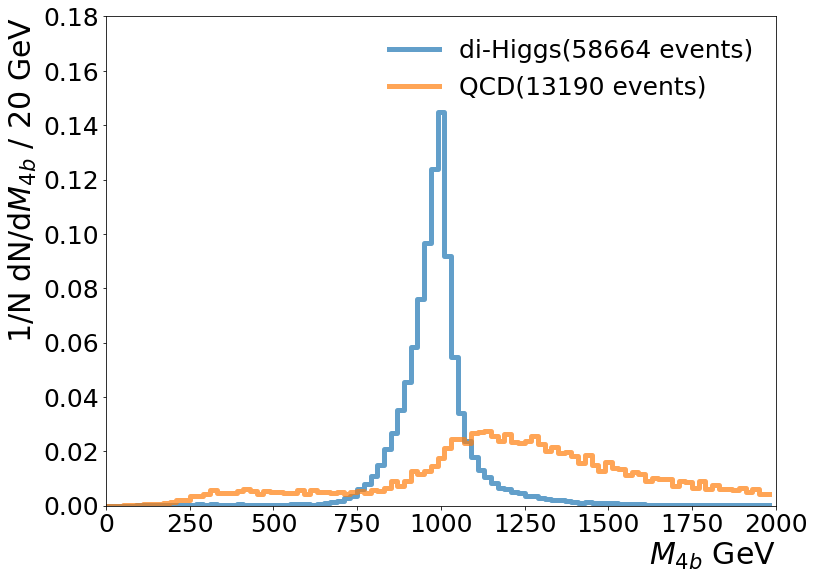

In [96]:
fig, ax = plt.subplots(1,1, figsize=(12,9))
length = np.linspace(0,2000,101)

hist, bins = np.histogram(M_JJ[0], bins=length)
plt.step(bins[:-1], 
         hist.astype(np.float32) / hist.sum() ,
         where='mid',
         linewidth=5, 
         alpha=0.7,
         label="di-Higgs({} events)".format(len(M_JJ[0])))

hist, bins = np.histogram(M_JJ[1], bins=length)
plt.step(bins[:-1], 
         hist.astype(np.float32) / hist.sum() ,
         where='mid',
         linewidth=5, 
         alpha=0.7,
         label="QCD({} events)".format(len(M_JJ[1])))

ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
plt.xlim((0,2000))
plt.xlabel("$M_{4b}$ GeV", fontsize=30,horizontalalignment='right',x=1) 

plt.legend(loc="upper right",ncol=1,fontsize=25, edgecolor = "w",fancybox=False, framealpha=0)
    
plt.ylim((0., 0.18))
plt.ylabel("1/N dN/d$M_{4b}$ / 20 GeV", fontsize=30, horizontalalignment='right',y=1)
plt.show() 

# Jet Trimmimng

In [105]:
process_list_clustered_trimmed = [[],[]]
#process_list_clustered
for N, process in enumerate(Higgs_candidate):
#     print(time.strftime("%a %b %d %H:%M:%S %Y", time.localtime()))
    ticks_1 = time.time()
    
    for jets in tqdm(process):
        jet_trimmed_list = []
#         if len(jets) < 2:
#             continue
        for jet_untrimmed in jets:
            jet_trimmed = jet_trim(jet_untrimmed)[0]
            jet_trimmed_list.append(jet_trimmed)
        
        process_list_clustered_trimmed[N].append(jet_trimmed_list)
        
    ticks_2 = time.time()
    totaltime =  ticks_2 - ticks_1
    print("\033[3;33mTime Cost : {:.4f} min\033[0;m".format(totaltime/60.))
    
    time.sleep(1)

100%|██████████| 58664/58664 [00:24<00:00, 2397.73it/s]


Time Cost : 0.4080 min


100%|██████████| 13190/13190 [00:05<00:00, 2342.96it/s]


Time Cost : 0.0939 min


In [88]:
print("# of di-Higgs: ", len(process_list_clustered_trimmed[0]))
print("# of QCD: ", len(process_list_clustered_trimmed[1]))

# of di-Higgs:  58664
# of QCD:  13190


# di-Jet Events' Selection From Truth Record

In [110]:

M_J1 = [[],[]]
M_J2 = [[],[]]
M_J3 = [[],[]]
M_J4 = [[],[]]
PT_J1 = [[],[]]
PT_J2 = [[],[]]
PT_J3 = [[],[]]
PT_J4 = [[],[]]
Mhh = [[],[]]
event_sele = [[],[]]


for N,(process_untrimmed, process_trimmed) in enumerate(zip(Higgs_candidate, process_list_clustered_trimmed)):   
    ticks_1 = time.time()
    
    trigger, two_jets  = 0, 0
    eta13, xhh = 0, 0
    
    for i in range(len(process_untrimmed)):
        
        """
        Trigger
        """
        if ET(process_untrimmed[i][0]) < 420 or process_untrimmed[i][0].mass < 35:
            trigger += 1
            continue
            
        """
        >= 2 jets
        """
        if len(process_trimmed[i]) < 2:
            two_jets += 1
            continue
            
        jet_1 = process_trimmed[i][0] #leading jet's information
        jet_2 = process_trimmed[i][1] #subleading jet's information
        
        
        if (jet_1.pt < 250) or (jet_2.pt < 250) :
            two_jets += 1
            continue
                
        if (abs(jet_1.eta) >= 2) or (jet_1.mass <= 50) :
            two_jets += 1
            continue
                
        if (abs(jet_2.eta) >= 2) or (jet_2.mass <= 50) :
            two_jets += 1
            continue
        
        if (jet_1.pt <= 450) :
            two_jets += 1
            continue
                
                    
        """
        |\Delta\eta| < 1.3
        """        
        if (abs(jet_1.eta - jet_2.eta) > 1.3) :
            eta13 += 1
            continue
                
                
        """
        X_HH < 1.6
        """        
        if XHH(jet_1,jet_2) >= 1.6 :
            xhh += 1
            continue
        
    
        M_J1[N].append(jet_1.mass)
        PT_J1[N].append(jet_1.pt)
        M_J2[N].append(jet_2.mass)
        PT_J2[N].append(jet_2.pt)
        Mhh[N].append(MJJ(jet_1,jet_2))

        event_sele[N].append(i)
        
    pass_trigger = len(process_untrimmed)-trigger
    pass_two_jets = len(process_untrimmed)-trigger-two_jets
    pass_eta13 = len(process_untrimmed)-trigger-two_jets-eta13
    pass_X_HH = len(process_untrimmed)-trigger-two_jets-eta13-xhh
    
    print("###############")
    print("There are {} events passed trigger selection. eff: {:.3f}. ".format(pass_trigger, pass_trigger/len(process_untrimmed)))
    print("There are {} events passed 2 jets selection. eff: {:.3f}. ".format(pass_two_jets, pass_two_jets/len(process_untrimmed)))
    print("There are {} events passed |\Delta\eta| selection. eff: {:.3f}. ".format(pass_eta13, pass_eta13/len(process_untrimmed)))
    print("There are {} events passed XHH selection. eff: {:.3f}. ".format(pass_X_HH, pass_X_HH/len(process_untrimmed)))
    print("There are {} events passed all selection.".format(len(M_J1[N])))
    print("\n")
    
    ticks_2 = time.time()
    totaltime =  ticks_2 - ticks_1
    print("\033[3;33mTime Cost : {:.4f} min\033[0;m".format(totaltime/60.))
    print("\n")

###############
There are 46915 events passed trigger selection. eff: 0.800. 
There are 26313 events passed 2 jets selection. eff: 0.449. 
There are 25331 events passed |\Delta\eta| selection. eff: 0.432. 
There are 2891 events passed XHH selection. eff: 0.049. 
There are 2891 events passed all selection.


Time Cost : 0.0078 min


###############
There are 12436 events passed trigger selection. eff: 0.943. 
There are 7569 events passed 2 jets selection. eff: 0.574. 
There are 5278 events passed |\Delta\eta| selection. eff: 0.400. 
There are 22 events passed XHH selection. eff: 0.002. 
There are 22 events passed all selection.


Time Cost : 0.0015 min




## Example 1: Plot in differential number of event

In [97]:
def HIST(process, length, title, colors, linestyle,xpo=1,ypo=1):
    hist, bins = np.histogram(process, bins=length)
    plt.step(bins[:-1], hist.astype(np.float32) / hist.sum(), linestyle ,color= colors ,where='mid',linewidth=5, alpha=0.7, label=title[i])
    plt.legend(loc="best",ncol=1,fontsize=25, edgecolor = "w",fancybox=False, framealpha=0)
    

# title = ["Herwig angular (H->hh)","Pythia default (H->hh)",#"Pythia vincia (H->hh)", "Pythia dipole (H->hh)",
#          "Herwig angular(QCD)", "Pythia default(QCD)"]#, "Pythia vincia(QCD)", "Pythia dipole(QCD)"]
# colors = ["green","red","blue","purple"]#,
#           "cyan","black","Orange","lightblue"]


title = ["Pythia default (H->hh)","Pythia default(QCD)"]
colors = ["green","red"]
linestyle = ["-","-."]


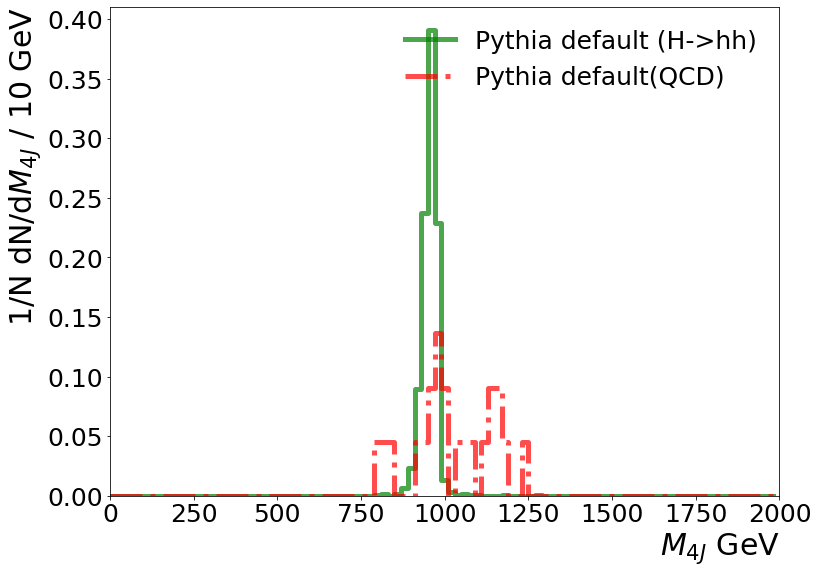

In [98]:
M_bbbb = Mhh

fig, ax = plt.subplots(1,1, figsize=(12,9))
for i, process in enumerate(M_bbbb):
    length = np.linspace(0,2000,101)
    HIST(process, length, title,colors[i],linestyle[i])
    ax.tick_params(axis='x', labelsize=25)
    ax.tick_params(axis='y', labelsize=25)
    plt.xlim((0,2000))
    plt.xlabel("$M_{4J}$ GeV", fontsize=30,horizontalalignment='right',x=1) 

    
plt.ylim((0.))
plt.ylabel("1/N dN/d$M_{4J}$ / 10 GeV", fontsize=30, horizontalalignment='right',y=1)
# plt.savefig("./Plots/m_ww_parton.png", transparent=True, bbox_inches='tight')  #save figure as png
plt.show() 

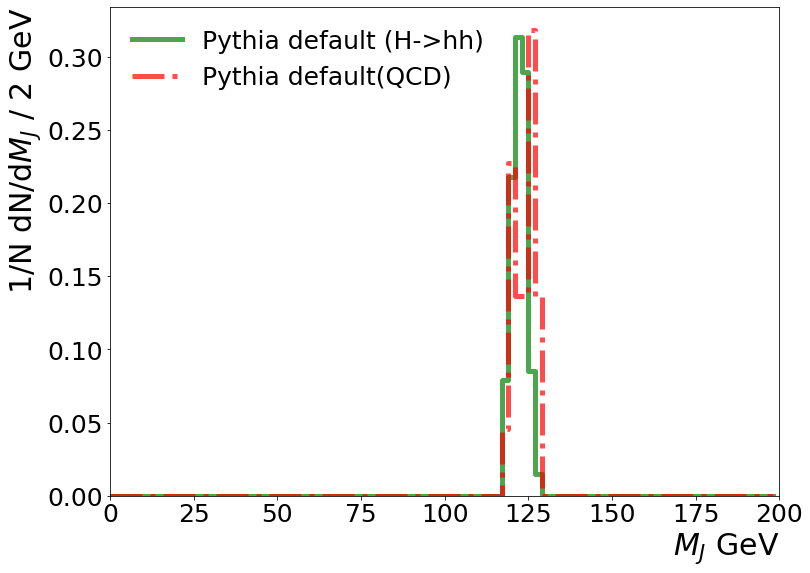

In [99]:
M_j = M_J1

fig, ax = plt.subplots(1,1, figsize=(12,9))
for i, process in enumerate(M_j):
    length = np.linspace(0,200,101)
    HIST(process, length, title,colors[i],linestyle[i])
    ax.tick_params(axis='x', labelsize=25)
    ax.tick_params(axis='y', labelsize=25)
    plt.xlim((0,200))
    plt.xlabel("$M_{J}$ GeV", fontsize=30,horizontalalignment='right',x=1) 

    
plt.ylim((0.))
plt.ylabel("1/N dN/d$M_{J}$ / 2 GeV", fontsize=30, horizontalalignment='right',y=1)
# plt.savefig("./Plots/m_ww_parton.png", transparent=True, bbox_inches='tight')  #save figure as png
plt.show()    
    

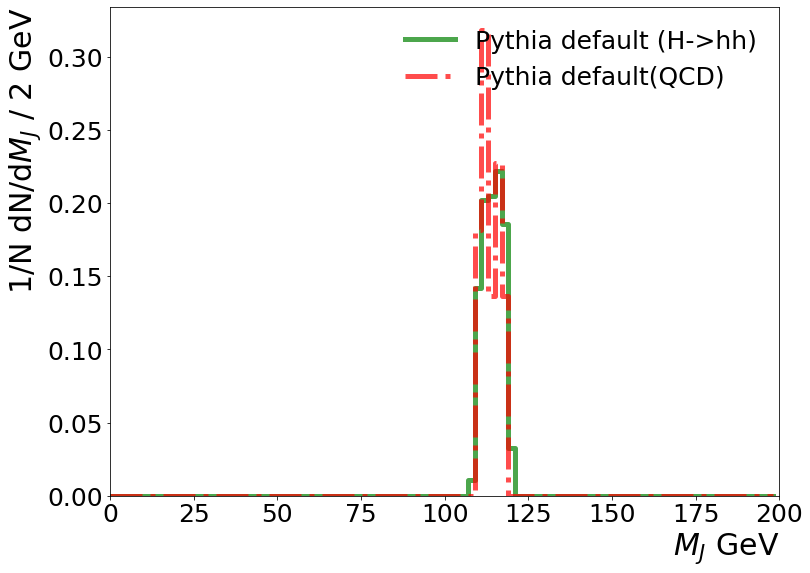

In [100]:
M_j = M_J2

fig, ax = plt.subplots(1,1, figsize=(12,9))
for i, process in enumerate(M_j):
    length = np.linspace(0,200,101)
    HIST(process, length, title,colors[i],linestyle[i])
    ax.tick_params(axis='x', labelsize=25)
    ax.tick_params(axis='y', labelsize=25)
    plt.xlim((0,200))
    plt.xlabel("$M_{J}$ GeV", fontsize=30,horizontalalignment='right',x=1) 

    
plt.ylim((0.))
plt.ylabel("1/N dN/d$M_{J}$ / 2 GeV", fontsize=30, horizontalalignment='right',y=1)
# plt.savefig("./Plots/m_ww_parton.png", transparent=True, bbox_inches='tight')  #save figure as png
plt.show()  

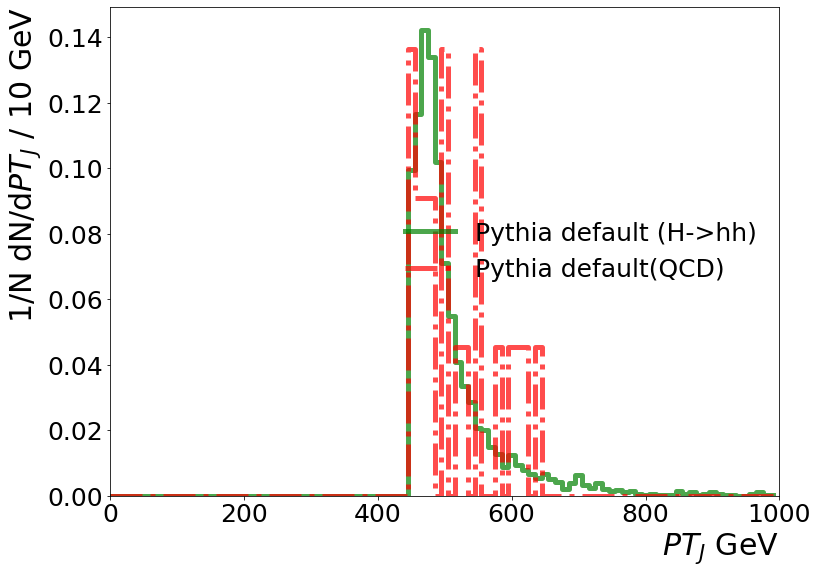

In [101]:
PT_j = PT_J1

fig, ax = plt.subplots(1,1, figsize=(12,9))
for i, process in enumerate(PT_j):
    length = np.linspace(0,1000,101)
    HIST(process, length, title,colors[i],linestyle[i])
    ax.tick_params(axis='x', labelsize=25)
    ax.tick_params(axis='y', labelsize=25)
    plt.xlim((0,1000))
    plt.xlabel("$PT_{J}$ GeV", fontsize=30,horizontalalignment='right',x=1) 

    
plt.ylim((0.))
plt.ylabel("1/N dN/d$PT_{J}$ / 10 GeV", fontsize=30, horizontalalignment='right',y=1)
# plt.savefig("./Plots/m_ww_parton.png", transparent=True, bbox_inches='tight')  #save figure as png
plt.show()    

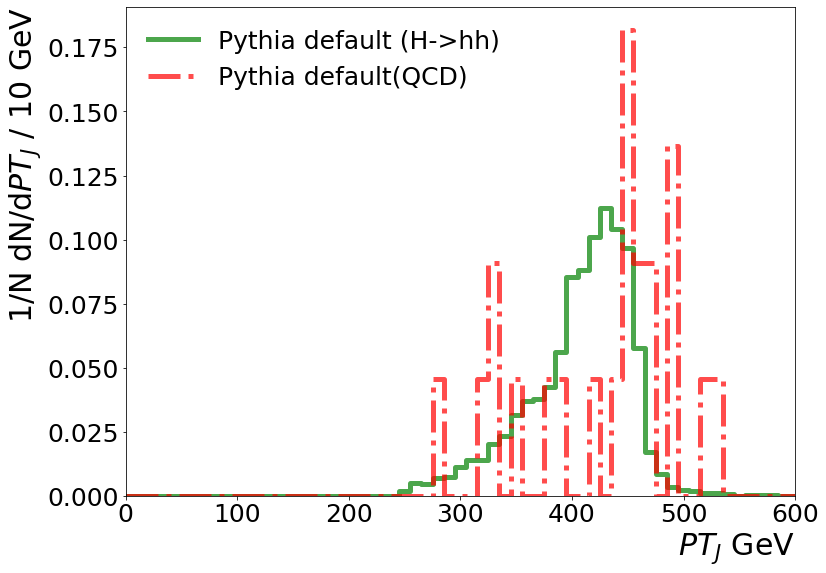

In [102]:
PT_j = PT_J2

fig, ax = plt.subplots(1,1, figsize=(12,9))
for i, process in enumerate(PT_j):
    length = np.linspace(0,1000,101)
    HIST(process, length, title,colors[i],linestyle[i])
    ax.tick_params(axis='x', labelsize=25)
    ax.tick_params(axis='y', labelsize=25)
    plt.xlim((0,1000))
    plt.xlabel("$PT_{J}$ GeV", fontsize=30,horizontalalignment='right',x=1) 

    
plt.ylim((0.))
plt.xlim((0.,600))
plt.ylabel("1/N dN/d$PT_{J}$ / 10 GeV", fontsize=30, horizontalalignment='right',y=1)
# plt.savefig("./Plots/m_ww_parton.png", transparent=True, bbox_inches='tight')  #save figure as png
plt.show()   

# Print jets in the Nth event

In [ ]:
# index = 0
# N = 0

# for i, jets in enumerate(event_list_clustered[index][N]):
#     print("{}".format("No." +str(i)+" Jet's Information"))
#     print(jets)
#     print("-------------------------------------------------------------------------")
#     print("{:^19} {:^20} ".format("Constituent's PID","Constituent's Four Momentum"))
#     print("-------------------------------------------------------------------------")
    
#     for constituent in jets: # get constituent in each "jet_element"
#         print("{:^19} {} {:^19} ".format(int(constituent.PID), constituent, int(constituent.Charge)))
#     print("-------------------------------------------------------------------------")

# Print the Truth Record in an Event

In [ ]:
# GenParticle = GenParticle_herwig_angular_H



# print("There are {} information in this event.".format(len(GenParticle.Status[0])))
# print("GenParticle Information")
# print("{:^5}{:^7}{:^7}{:^7}{:^7}{:^7}{:^7}{:^8}{:^8}{:^8}{:^8}".format("#","Status","PID", "M1", "M2", "D1", "D2", "PT", "Eta","Phi", "Mass"))

# index = 0## which event you want to print out
# k = 0
# for j in range(len(GenParticle.Status_At(index))):
    
#     if GenParticle.Status_At(index)[j] == 2: ##Selet the Stable Final State Particles
# #     if np.abs(GenParticle.PID_At(index)[j]) == 5 or np.abs(GenParticle.PID_At(index)[j]) == 5:

# #     if np.abs(GenParticle.PID_At(index)[GenParticle.M1_At(index)[j]]) == 24 or np.abs(GenParticle.PID_At(index)[GenParticle.M2_At(index)[j]]) == 24:
# #         if np.abs(GenParticle.PID_At(index)[GenParticle.M1_At(index)[j]]) == 23 or np.abs(GenParticle.PID_At(index)[GenParticle.M2_At(index)[j]]) == 23:

#         print("{:^5}{:^7}{:^7}{:^7}{:^7}{:^7}{:^7}{:^8.2}{:^8.2}{:^8.2}{:^8.2}".format( \
#         j, GenParticle.Status_At(index)[j],  GenParticle.PID_At(index)[j], GenParticle.M1_At(index)[j], GenParticle.M2_At(index)[j],
#          GenParticle.D1_At(index)[j], GenParticle.D2_At(index)[j],  GenParticle.PT_At(index)[j],  GenParticle.Eta_At(index)[j], GenParticle.Phi_At(index)[j], GenParticle.Mass_At(index)[j]))

# #             k +=1
# # print(k)

# Detector Level

In [12]:
# Jet_herwig_angular_H = BranchJet(herwig_angular_H)
# def Jet_List(Jet):
#     print(time.strftime("%a %b %d %H:%M:%S %Y", time.localtime()))
#     ticks_1 = time.time()
    
#     k = 0
#     Jet_list = []
    
#     for N in range(Jet.length):
        
#         Jet_list_tmp = []
#         Jet_list_tmp_tmp = []


#         Jet_list_tmp.append([Jet.PT_At(N),  Jet.Eta_At(N), \
#                                Jet.Phi_At(N), Jet.Mass_At(N), \
#                                Jet.Charge_At(N), Jet.BTag_At(N)
#                               ])


        
#         Jet_list_tmp = np.array(Jet_list_tmp)

#         Jet_list_tmp = Jet_list_tmp[0]#[:,Jet_list_tmp[0][5,:]==1]
# #         Jet_list_tmp = Jet_list_tmp[:,np.abs(Jet_list_tmp[4,:])!=12]
# #         Jet_list_tmp = Jet_list_tmp[:,np.abs(Jet_list_tmp[4,:])!=14]
# #         Jet_list_tmp = Jet_list_tmp[:,np.abs(Jet_list_tmp[4,:])!=16]
        
#         Jet_list.append(Jet_list_tmp)

#     ticks_2 = time.time()
#     totaltime =  ticks_2 - ticks_1
#     print("\033[3;33mTime Cost : {:.4f} min\033[0;m".format(totaltime/60.))
    
#     return Jet_list

# Jet_herwig_H = Jet_List(Jet_herwig_angular_H)